In [36]:
import numpy as np
from importlib import reload
import sys
import os
import pandas as pd

BASE_DIR = os.path.abspath("..")
if BASE_DIR not in sys.path:
    sys.path.append(BASE_DIR)

import matplotlib.pyplot as plt

import Eigen.PageRank
reload(Eigen.PageRank)
from Eigen.PageRank import page_rank


import utils.read_data 
reload(utils.read_data)
from utils.read_data import read_pages

import utils.draw_graph
reload(utils.draw_graph)
from utils.draw_graph import draw_graph



# First step

Into the cell below are called two functions:

1) the first function read the data from the dataset
2) the second function plots a random subweb to have a look to the dataset

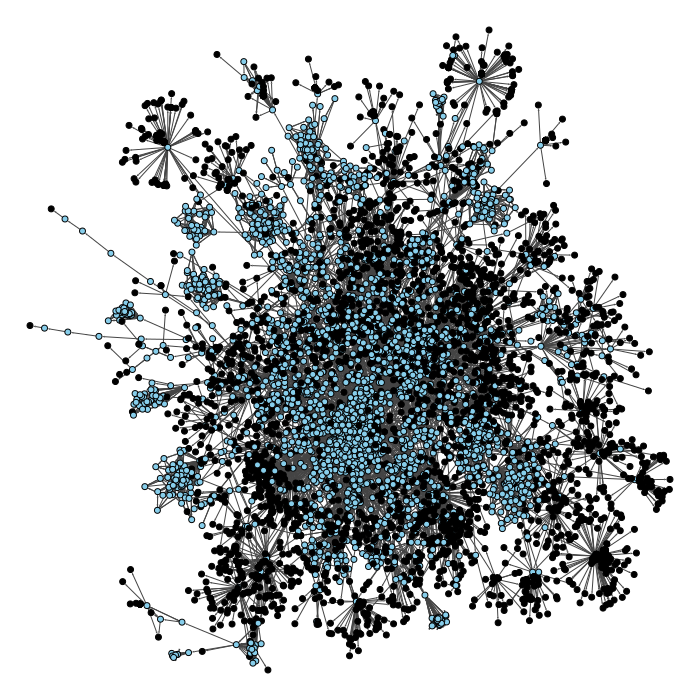

In [37]:
file_path = "DataSet/hollins.dat"
seed = 900
fig_size=(7,7)
lay = "fr"   # try "fr", "kk", "circle", "grid", "tree", lgl, auto, random, drl    best = fr


A,node_map,edges, sink_nodes = read_pages(file_path)
n = A.shape[0]
false_node = n - 1   # index of the false node = 6012
valid_nodes = list(range(n))
valid_nodes.remove(false_node)

sample_size = len(valid_nodes)
sampled_nodes_list = list(range(n))
sampled_nodes_list.remove(false_node)  

sampled_nodes, layout_cords  = draw_graph(A,sample_size=sample_size, sampled_nodes=sampled_nodes_list, seed = 9, fig_size=fig_size, lay = lay)

# Power method

In the cell below is applied the Power Method for computing the score 

The Power Method compute the eigenvector with the highest magnitude 

The algorithm is the following:

**Input:**
- Square Matrix $\mathbf{A} \in \mathbb{R}^{n \times n} $
- the factor $m\in[0,1]$
- initial guess vector $ \mathbf{x}^{(0)} \in \mathbb{R}^n $
- maxIter $ k_{\max} $
- Tol $ \varepsilon $

**Output:**
- Approximation of the dominant eigenvalue $ \lambda $
- Approximation of the dominant eigenvector $ \mathbf{x}^{(k+1)} $
- Iteration needed $k +1$

---

**Algorithm:**

1. Normalize the vector:
   $
   x^{(0)} \leftarrow \frac{\mathbf{x}^{(0)}}{\|\mathbf{x}^{(0)}\|_1}
   $

2. For $ k= 0,1,2,\dots,k_{\max} $
   
   1. Compute:
      $
      \mathbf{y}^{(k+1)} = (1-m)\mathbf{A x}^{(k)}+m\mathbf{S}
      $
   
   2. Normalize:
      $
      \mathbf{x}^{(k+1)} = \frac{\mathbf{y}^{(k+1)}}{\|\mathbf{y}^{(k+1)}\|_1}
      $
   

   3. if:
      $
      \| \mathbf{x}^{(k+1)} - \mathbf{x}^{(k)} \|_1 < \varepsilon
      $
      break.
    
3. Eigenvalue extimation :
      $
      \lambda = (x^{(k+1)})^\top y^{(k+1)}
      $

3. Return $ x^{(k+1)} ,  \lambda, k+1 $



The method stopped before k= 10000
number of iteration needed k= 72


value of c compared to |1-2*m/n|
0.9999501080991186
0.9999501080991186
the approximation of the eigenvalue with the highest magnitude
1.0206646296576614


/tmp/ipykernel_7952/3886736118.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


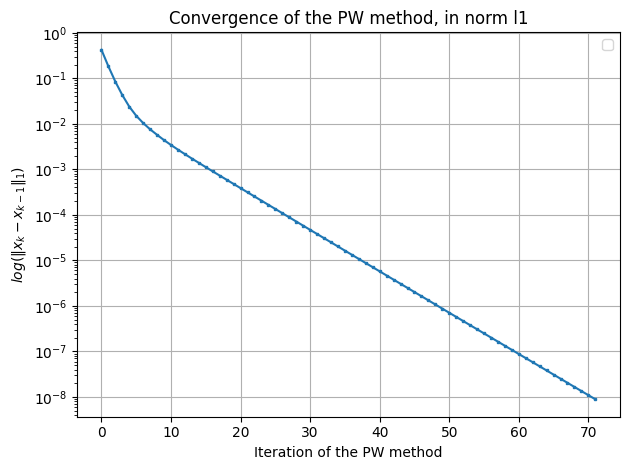

In [38]:
x_0 = np.ones((A.shape[0],1))
m = 0.15
#name = "error_with_m_099.png"
score,lam,c,p,diff = page_rank(A,m,x_0,sink_nodes,k=10000)

print("number of iteration needed k=",p)
print("\n")
print("value of c compared to |1-2*m/n|")
print(c)
print(abs(1-2*m/n))  # I claim that max_i|1-2min_j M_ij| = |1-2*m/n|
print("the approximation of the eigenvalue with the highest magnitude")
print(lam)

plt.plot(range(0, p), diff, marker='s', markersize=2)
plt.xlabel("Iteration of the PW method")
plt.ylabel(r"$ log(\|x_k - x_{k-1}\|_1)$")
plt.title("Convergence of the PW method, in norm l1")
plt.legend()
plt.yscale("log")
plt.grid(True)
plt.tight_layout()
#plt.savefig(name, format="png", dpi=300, bbox_inches="tight", pad_inches=0.3)
plt.show()

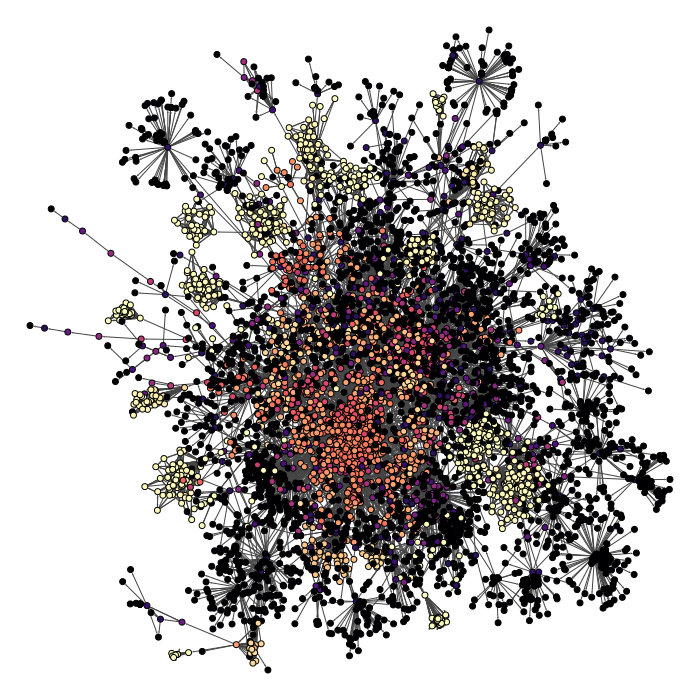

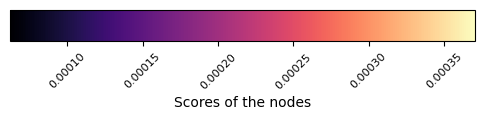

In [39]:
color_map = 'magma'   #'viridis' , 'RdYlBu_r' , 'inferno' , 'magma', 'cividis', 'Greys', 'Blues', 'Greens', 'Oranges', 'Purples'
_,_ = draw_graph(A,sampled_nodes=sampled_nodes, sample_size=sample_size, seed = seed, values = score, cmap=color_map, fig_size=fig_size, lay = lay, layout_coords=layout_cords)

In [40]:
# forward and backlinks
out_deg = {}
in_deg = {}
backlinks = {}  

for src, dst in edges:
    out_deg[src] = out_deg.get(src, 0) + 1
    in_deg[dst] = in_deg.get(dst, 0) + 1
    backlinks.setdefault(dst, []).append(src)

#Table
false_node_id = max(node_map.keys())  # 6013

data = []
for node_id, url in node_map.items():
    if node_id == false_node_id:
        continue  # skip False_Page

    sc = score[node_id - 1][0]  # 
    incoming = in_deg.get(node_id, 0)
    outcoming = out_deg.get(node_id, 0)

    # average score of the backlinks, 
    incoming_nodes = [src for src in backlinks.get(node_id, []) if src != false_node_id]
    if incoming_nodes:
        avg_backlink_score = sum(score[src - 1][0] for src in incoming_nodes) / len(incoming_nodes)
    else:
        avg_backlink_score = 0.0

    is_sink = (node_id in sink_nodes)
    if is_sink:
        outcoming -=0      # 1 if there is a connection with the false node

    data.append((url, sc, incoming, outcoming, avg_backlink_score, is_sink))

df = pd.DataFrame(data, columns=['page', 'score', 'Num backlinks', 'Num forwardlinks', 'Avg score of the backlink pages', 'Sink Page'])

# sorting
df = df.sort_values(by='score', ascending=False).reset_index(drop=True)

styled_df = (
    df.style
    .format({"score": "{:.5e}", "Avg score of the backlink pages": "{:.5e}"})
    .background_gradient(subset=['score','Avg score of the backlink pages'], cmap=color_map) 
    .set_table_styles(
        [{'selector': 'th', 'props': [('text-align', 'center')]}]  
    ) 
    #.bar(subset=['backlinks', 'forwardlinks'], color='lightblue')
    .set_properties(**{'text-align': 'center'})
    .hide(axis='index')
)

display(styled_df)